 # The Role of the Third Sector in Public Health Service Provision
 
 ## By Charles Rahal and John Mohan
 
 #### Last Updated: 20/07/2020

The role and extent of external suppliers across statutory health insurance procurement processes varies widely and is a source of political contention throughout the modern world. We examine the role of the Third Sector in public health procurement within publicly funded healthcare which runs parallel to private provision in a ‘two-tier’ system. We build a unique ‘Big Data’ based methodological pipeline which scrapes tens of thousands of heterogeneous accounting datasets from decentralised Clinical Commissioning Groups and Trusts within the National Health Service. These datasets provide granular information on every element of procurement at the micro-level (where the value of a transaction is greater than twenty-five thousand pounds), mandated by transparency requirements introduced by David Cameron in 2012. We develop data scientific tools to parse these datasets and reconcile suppliers with institutional registers, with a focus on charities registered on the Charity Commission for England and Wales (CCEW). The processed dataset contains almost six hundred billion pounds worth of commissioning and over two million rows of clean data. Our substantive findings are five-fold. First, we estimate that approximately X\% of the suppliers are listed on the CCEW, but account for only Y\% of the total procurement process. Second, we show huge regional variation in the procurement from the Third Sector. Linking to the International Classification of Nonprofit Organizations (ICNPO), we show a ranged involvement of charities predominantly focused within the Health area. Fourth, we analyse the distribution of contracts to charities across various sizes, from grass-roots to ‘mega’ charitable companies. Finally, we show the time-varying nature of this involvement, driven by large institutional contracts to ‘mega-charities’. The accompanying supplementary material provides technical details of our unique methodological approach, validates our dataset, and introduces our online interactive application.

### 1.1 Lets load some dependancies

Load in all of the libraries (`pip install requirements.txt` in '..') and custom functions specifically created for this project which are found in `analysis\general_analysis_functions.py` and `analysis\charity_analysis_functions.py`.

In [1]:
import os
import pandas as pd
from helper_functions import hide_toggle
from general_analysis_functions import (load_suppliers,
                                        load_payments,
                                        scoring_figures,
                                        summarize_payments,
                                        plot_match_distribution,
                                        summarize_payments,
                                        plot_macro_overview,
                                        analyze_registers,
                                        calc_total_files,
                                        make_table_one,
                                        check_payments)
from charity_analysis_functions import (tabulate_charities,
                                        icnpo_groupings,
                                        load_ccname,
                                        load_ccfin,
                                        load_ccclass,
                                        load_icpno,
                                        build_charity_df,
                                        make_gdf,
                                        make_ccg_to_gdf,
                                        plot_choropleths_ccg,
                                        plot_choropleths_trusts,
                                        plot_heatmaps,
                                        make_monthly,
                                        make_annual,
                                        charity_age,
                                        more_or_less_by_age,
                                        class_groupings,
                                        make_temporal_df,
                                        plot_temporal
                                       )
%load_ext autoreload
%autoreload 2
hide_toggle()

### 1.2 Set paths

Lets now set all of the paths were going to need later on in the notebook.

In [2]:
data_path = os.path.abspath(os.path.join(os.getcwd(), '../..', 'data'))
cc_path = os.path.join(data_path, 'data_cc')
ch_path = os.path.join(data_path, 'data_ch')
nhsdigital_path = os.path.join(data_path, 'data_nhsdigital')
master_path = os.path.join(data_path, 'data_masteringest')
merge_path = os.path.join(data_path, 'data_merge')
recon_path = os.path.join(data_path, 'data_reconciled')
norm_path = os.path.join(data_path, 'data_support', 'norm_dict.tsv')
support_path = os.path.join(data_path, 'data_support')
shape_path = os.path.join(data_path, 'data_shapefiles')
figure_path = os.path.abspath(os.path.join(
                              os.path.join(os.getcwd(),
                                           '../..', 'papers', 'figures')))
table_path = os.path.abspath(os.path.join(
                             os.path.join(os.getcwd(),
                                          '../..', 'papers', 'tables')))
hide_toggle()

### 1.2 Load key datasets

Lets now load the hard earned datasets from all the data creation pipeline.

In [3]:
sup_df = load_suppliers(os.path.join(recon_path, 'recon_verified.tsv'))
ccg_pay_df = load_payments(os.path.join(merge_path, 'ccg_merged_with_recon.tsv'))
trust_pay_df = load_payments(os.path.join(merge_path, 'trust_merged_with_recon.tsv'))
cc_name = load_ccname(cc_path, norm_path)
icnpo_df, icnpo_lookup = load_icpno(support_path)
cc_fin = load_ccfin(cc_path)
cc_class = load_ccclass(cc_path)
hide_toggle()

### 1.3 Plot a general overview of some national accounting data

See the figure note in the paper for more details on exactly which data comes from where!

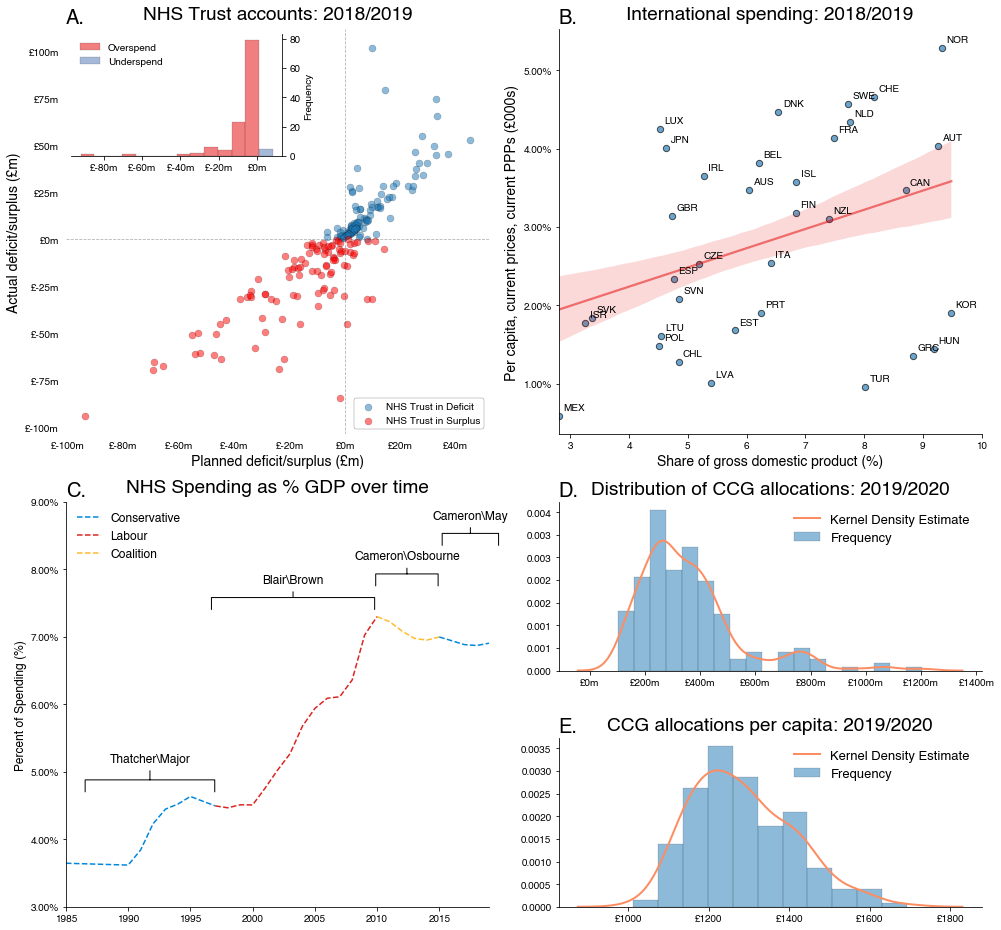

In [4]:
plot_macro_overview(data_path, figure_path)

## 2. Check and summarize the raw payments dataset

### 2.1 How many institutions were there at the time of the last scrape?

In [5]:
print('There are 221 Trusts in our meta list.')
print('There are 191 Trusts in our meta list.')
hide_toggle()

There are 221 Trusts in our meta list.
There are 191 Trusts in our meta list.


### 2.2 How many files did we get?

In [6]:
ccg_rawpath = os.path.join(data_path, 'data_nhsccgs', 'raw')
trust_rawpath = os.path.join(data_path, 'data_nhstrusts', 'raw')
ccg_files = calc_total_files(ccg_rawpath)[0]
ccg_folders = calc_total_files(ccg_rawpath)[1]
print('CCG folders: ' +  str(ccg_folders))
print('CCG files: ' +  str(ccg_files))
trust_files = calc_total_files(trust_rawpath)[0]
trust_folders = calc_total_files(trust_rawpath)[1]
print('Trust folders: ' +  str(trust_folders))
print('Trust files: ' +  str(trust_files))
hide_toggle()

CCG folders: 192
CCG files: 12729
Trust folders: 216
Trust files: 12760


### 2.3 Check the raw payments here

Write a function which verifies our manual check of the 50 largest payments of each dataset (i.e. for bad potentially serious bad parses)

In [7]:
check_payments(ccg_pay_df,
               os.path.join(data_path,'data_support',
                            'filechecker_ccg.csv'), data_path, 'ccg', 50)
check_payments(trust_pay_df,
               os.path.join(data_path,'data_support',
                            'filechecker_trust.csv'), data_path, 'trust', 50)
hide_toggle()

Cool! No more ccg payments to check by order...
Cool! No more ccg payments to check by groupby...
Cool! No more trust payments to check by order...
Cool! No more trust payments to check by groupby...


### 2.4 Analyze institutional registers

Lets quickly check just how unique the actual institutions going into our match are!

In [8]:
#emphasize this point re: uniqueness in article and check that this is what code is doing
analyze_registers(ch_path, cc_path, nhsdigital_path, master_path)
hide_toggle()

Number unique raw CH entries: 4490685
Number non-duplicated normalized CH entries: 4489992
Number unique raw CC entries: 469691
Number non-duplicated normalized CC entries: 463733
Number unique raw NHS Digital entries: 45739
Number non-duplicated normalized NHS Digital entries: 45560
Number unique raw combined entries: 4851121
Number non-duplicated normalized combined entries: 4873882
There are 51575 normalised unique names on both CH and CC
There are 1408 normalised unique names on both CH and NHS
There are 1280 normalised unique names on both CC and NHS
There are 371 normalised unique names on all 3


### 2.5 Summarize the results of our data curation proceedure

Lets first summarize the payments from just CCGs:

In [9]:
summarize_payments(ccg_pay_df, 'CCG')
hide_toggle()

Describing cleaned CCG payments dataset!
Length of dataset: 589784
Total unique raw suppliers: 15698
Total unique verified suppliers: 7835
Total value (£) of dataset: 212036076347
Smallest value payment: 25000
Biggest value payment: 58249359
Average value payment: 359514
Earliest payment was: 2010-12-24 00:00:00
Latest payment was: 2020-02-29 00:00:00
Most payments is:  NHS_LEE_CCG (18197)
Highest value payments is: NHS_LEE_CCG (£6338077468)
Most payments: No Match (82274)
Highest value of payments is: No Match (17232401431.0)
Number of organisations in clean dataset is: 173
Number of files in clean dataset is: 7742


and then for just NHS Trusts...

In [10]:
summarize_payments(trust_pay_df, 'Trust')
hide_toggle()

Describing cleaned Trust payments dataset!
Length of dataset: 643819
Total unique raw suppliers: 24466
Total unique verified suppliers: 11191
Total value (£) of dataset: 89315266561
Smallest value payment: 25000
Biggest value payment: 139956473
Average value payment: 138727
Earliest payment was: 2010-01-04 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_GUY_Trust (26139)
Highest value payments is: NHS_IMP_Trust (£3979230540)
Most payments: No Match (65365)
Highest value of payments is: No Match (12444255825.310001)
Number of organisations in clean dataset is: 189
Number of files in clean dataset is: 8587


And then for a merged dataframe of both CCGs and NHS Trusts:

In [11]:
summarize_payments(pd.concat([trust_pay_df, ccg_pay_df],
                             ignore_index=True), 'Combined')
hide_toggle()

Describing cleaned Combined payments dataset!
Length of dataset: 1233603
Total unique raw suppliers: 38145
Total unique verified suppliers: 17271
Total value (£) of dataset: 301351342908
Smallest value payment: 25000
Biggest value payment: 139956473
Average value payment: 244285
Earliest payment was: 2010-01-04 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_GUY_Trust (26139)
Highest value payments is: NHS_LEE_CCG (£6338077468)
Most payments: No Match (147639)
Highest value of payments is: No Match (29676657256.31)
Number of organisations in clean dataset is: 362
Number of files in clean dataset is: 16238


### 2.6 Make Table One

And then wrangle this data into what goes into Table One in the accompanying paper:

In [12]:
make_table_one(ccg_pay_df, trust_pay_df, table_path)
hide_toggle()

## 3 Visualise the approximate matches

Lets see how our matching algorithms perform by plotting Elastic Search match scores against Levenhstein ones

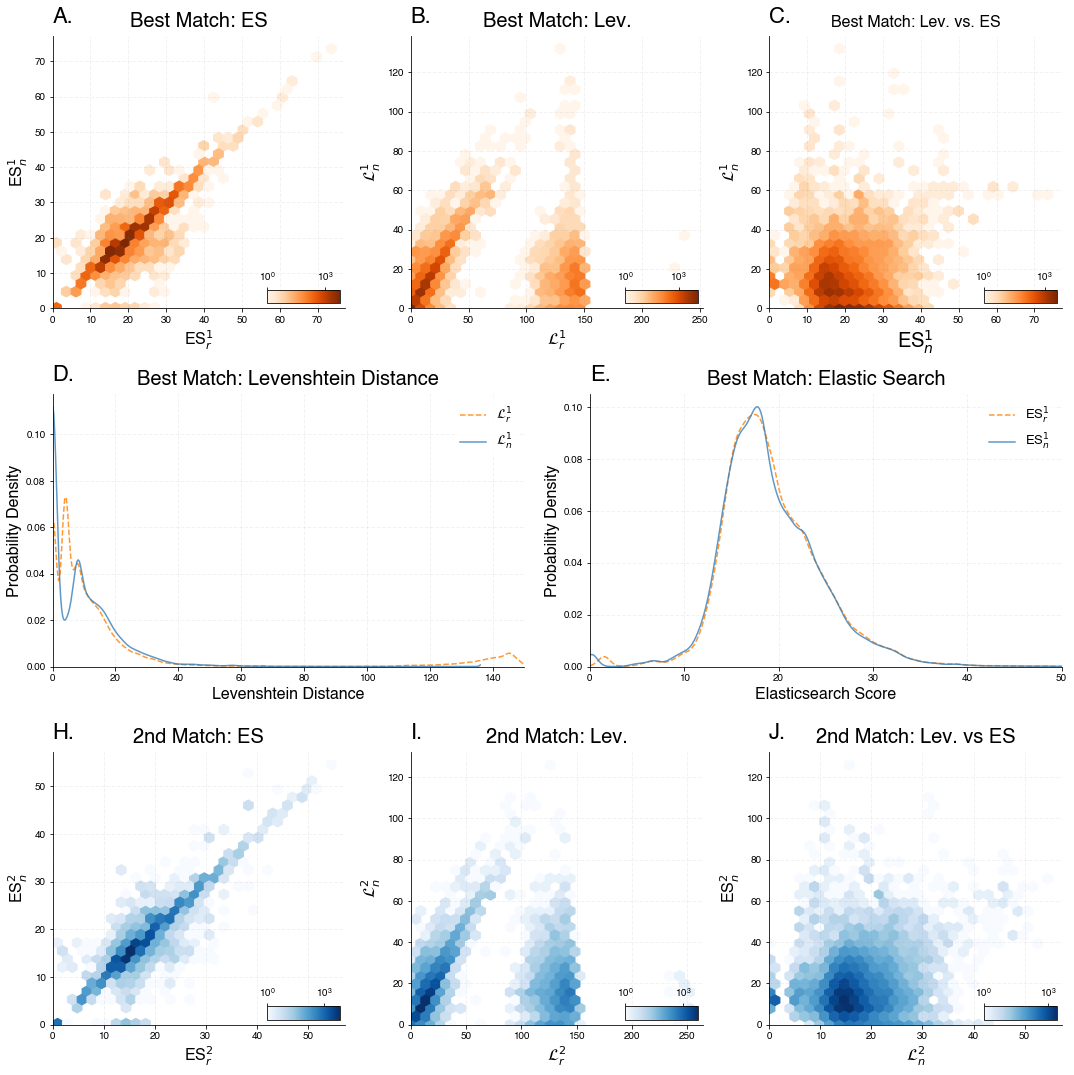

In [13]:
scoring_figures(sup_df, figure_path, (15, 15))
hide_toggle()

## 4 Visualise the institutional distribution

Where does the money go? lets plot an 'infographic' style thing with various measures

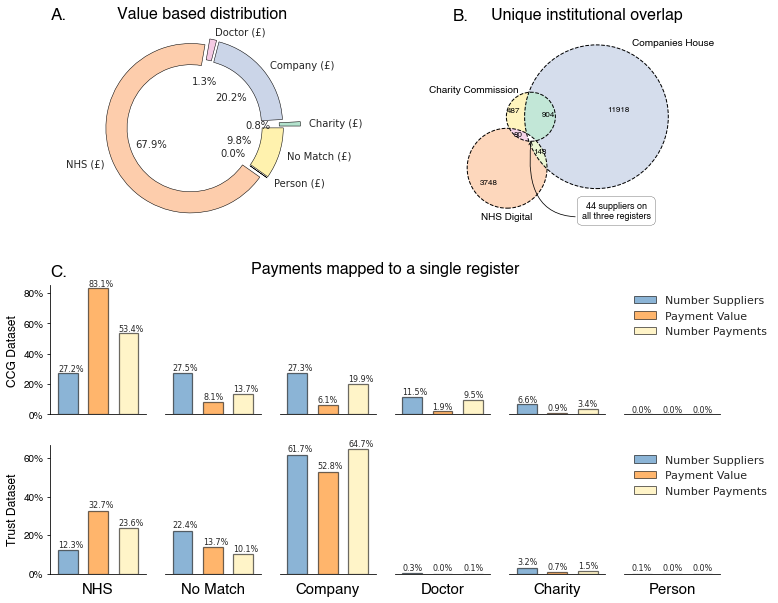

In [14]:
plot_match_distribution(sup_df, trust_pay_df, ccg_pay_df, figure_path, (12, 10))
hide_toggle()

## 5. Summarsize charitable payments and suppliers

Lets now get to the crux of the matter for the main charitable analysis paper: where does the money actually go within the charity sector?

### 5.0 Build charity dataframe

Lets build some charity specific dataframes: these are for downstream analysis and only contain information on payments going to charities from trusts, ccgs, and trusts and ccgs combined

In [15]:
pay_df_cc_ccg, cc_sup_ccg = build_charity_df(ccg_pay_df,
                                             cc_name, icnpo_df, cc_fin, data_path)
hide_toggle()

We are missing 46 registration numbers
Can't do anything about that...
This seems to be where two charities have the same normalised name, and neither has been  removed from the register
This leaves us with 934 charities with regnos.
We are missing 129 incomes
Can't do anything about that...
We are missing 0 ICNPO numbers which have charity numbers


In [16]:
pay_df_cc_trust, cc_sup_trust = build_charity_df(trust_pay_df,
                                                 cc_name, icnpo_df, cc_fin, data_path)
hide_toggle()

We are missing 39 registration numbers
Can't do anything about that...
This seems to be where two charities have the same normalised name, and neither has been  removed from the register
This leaves us with 586 charities with regnos.
We are missing 96 incomes
Can't do anything about that...
We are missing 0 ICNPO numbers which have charity numbers


In [17]:
pay_df_cc, cc_sup = build_charity_df(pd.concat([trust_pay_df, ccg_pay_df],
                                         ignore_index=True),
                                         cc_name, icnpo_df, cc_fin, data_path)
hide_toggle()

We are missing 72 registration numbers
Can't do anything about that...
This seems to be where two charities have the same normalised name, and neither has been  removed from the register
This leaves us with 1358 charities with regnos.
We are missing 203 incomes
Can't do anything about that...
We are missing 0 ICNPO numbers which have charity numbers


### 5.1 Charity summary

Lets now see what our _charitable_ datasets look like, filtering only on payments which have gone to charitable institutions (which do possibly overlap onto other institutions). First for CCGs:

In [18]:
summarize_payments(pay_df_cc_ccg, 'charitable')
hide_toggle()

Describing cleaned charitable payments dataset!
Length of dataset: 21006
Total unique raw suppliers: 1079
Total unique verified suppliers: 980
Total value (£) of dataset: 1835041222
Smallest value payment: 25000
Biggest value payment: 3532145
Average value payment: 87357
Earliest payment was: 2012-09-28 00:00:00
Latest payment was: 2020-02-29 00:00:00
Most payments is:  NHS_LEE_CCG (1157)
Highest value payments is: NHS_LEE_CCG (£151281506)
Most payments: NUFFIELD HEALTH (2072)
Highest value of payments is: NUFFIELD HEALTH (279219952.0)
Number of organisations in clean dataset is: 167
Number of files in clean dataset is: 5779


Then for Trusts:

In [19]:
summarize_payments(pay_df_cc_trust, 'charitable')
hide_toggle()

Describing cleaned charitable payments dataset!
Length of dataset: 10055
Total unique raw suppliers: 753
Total unique verified suppliers: 622
Total value (£) of dataset: 690968209
Smallest value payment: 25000
Biggest value payment: 2350782
Average value payment: 68718
Earliest payment was: 2010-01-29 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_CUH_Trust (620)
Highest value payments is: NHS_CUH_Trust (£46042930)
Most payments: ST JOHN AMBULANCE (833)
Highest value of payments is: ST JOHN AMBULANCE (39595320.0)
Number of organisations in clean dataset is: 170
Number of files in clean dataset is: 3481


And then for both combined:

In [20]:
summarize_payments(pay_df_cc, 'charitable')
hide_toggle()

Describing cleaned charitable payments dataset!
Length of dataset: 31061
Total unique raw suppliers: 1685
Total unique verified suppliers: 1427
Total value (£) of dataset: 2526009431
Smallest value payment: 25000
Biggest value payment: 3532145
Average value payment: 81324
Earliest payment was: 2010-01-29 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_LEE_CCG (1157)
Highest value payments is: NHS_LEE_CCG (£151281506)
Most payments: NUFFIELD HEALTH (2432)
Highest value of payments is: NUFFIELD HEALTH (300026063.0)
Number of organisations in clean dataset is: 337
Number of files in clean dataset is: 9229


### 5.2 Tabulate the charities (groupby)

Stack these first two tables together vertically in the paper. They show which charities are getting most money. The nameno which maps to the National Blood Authority is curious. First for CCGs:

In [21]:
tabulate_charities(pay_df_cc_ccg, cc_name, icnpo_df, cc_fin,
                   table_path, 'ccg_payments_to_charities.csv')
hide_toggle()

                       verif_match     amount  count    regno     regdate  ICNPO        income  CC Rank
                   NUFFIELD HEALTH  279219952   2072   205533  1962-09-22   3100  4.835600e+09        6
        MARIE STOPES INTERNATIONAL   41907581   1081   265543  1973-05-09   3400  1.603164e+09       58
                              BPAS   39187583    782   289145  1984-04-25   3400  2.078000e+08     1366
                       MARIE CURIE   54672375    515   207994  1962-09-22   3400  1.091030e+09      243
                ALZHEIMERS SOCIETY   22784246    479   296645  1987-04-23   3400  6.660080e+08      423
               ST BARNABAS HOSPICE   48084953    460  1053814  1996-03-15   3200  7.631532e+07     4444
             ST ANDREWS HEALTHCARE   14164414    385  1104951  2004-07-16   3300  1.369600e+09      192
                   METHODIST HOMES   14675393    350  1083995  2000-12-04   6200  1.429769e+09      178
 ALTERNATIVE FUTURES GROUP LIMITED   27303996    344  1008587  1

Then for trusts:

In [22]:
tabulate_charities(pay_df_cc_trust, cc_name, icnpo_df, cc_fin,
                   table_path, 'trust_payments_to_charities.csv')
hide_toggle()

                         verif_match    amount  count    regno     regdate  ICNPO        income  CC Rank
                   ST JOHN AMBULANCE  39595320    833  1077265  1999-09-02   3400  6.001000e+08      456
                       ANTHONY NOLAN  16712447    458   803716  1990-07-12   3400  2.935340e+08     1047
 THE ANTHONY NOLAN BONE MARROW TRUST  14229326    385   803716  1990-07-12   3400  2.935340e+08     1048
                     NUFFIELD HEALTH  20806111    360   205533  1962-09-22   3100  4.835600e+09        6
                  NUFFIELD HOSPITALS  17412931    236   205533  1962-09-22   3100  4.835600e+09        5
                       PHOENIX HOUSE  18403882    222   284880  1982-07-19   6200  1.642872e+08     1925
            NATIONAL BLOOD AUTHORITY  20883874    214  1061771  1997-04-10   3100  5.701230e+05    65465
                          THE PRIORY  24355276    179   273022  1979-08-15   6100  5.582131e+06    19737
                     PHOENIX FUTURES   8221068    176  

And then for both:

In [23]:
tabulate_charities(pay_df_cc, cc_name, icnpo_df, cc_fin,
                   table_path, 'both_payments_to_charities.csv')
hide_toggle()

                verif_match     amount  count    regno     regdate  ICNPO        income  CC Rank
            NUFFIELD HEALTH  300026063   2432   205533  1962-09-22   3100  4.835600e+09        6
 MARIE STOPES INTERNATIONAL   43530169   1112   265543  1973-05-09   3400  1.603164e+09       58
          ST JOHN AMBULANCE   39595320    833  1077265  1999-09-02   3400  6.001000e+08      456
                       BPAS   39187583    782   289145  1984-04-25   3400  2.078000e+08     1366
                MARIE CURIE   56955581    560   207994  1962-09-22   3400  1.091030e+09      243
         ALZHEIMERS SOCIETY   27012536    542   296645  1987-04-23   3400  6.660080e+08      423
        ST BARNABAS HOSPICE   48643690    469  1053814  1996-03-15   3200  7.631532e+07     4444
              ANTHONY NOLAN   16712447    458   803716  1990-07-12   3400  2.935340e+08     1047
            METHODIST HOMES   18200411    448  1083995  2000-12-04   6200  1.429769e+09      178
    THE RICHMOND FELLOWSHIP   

### 5.3 ICNPO and Class Distributions

#### 5.3.1. Lets first look at how this grouping looks over all ICNPO groups

In [24]:
icnpo_groupings(pay_df_cc, pay_df_cc_ccg, pay_df_cc_trust, 
                cc_name, icnpo_df, icnpo_lookup, table_path)
hide_toggle()

                             icnpo_group  count  amount  count_ccg  amount_ccg  count_trust  amount_trust
icnpo                                                                                                    
1100                   Culture and sport   2.36    0.54       1.50        0.59         3.08          0.42
1200                   Culture and sport   1.11    0.18       1.39        0.14         0.85          0.30
1300                   Culture and sport   0.07    0.00       0.11        0.00         0.00          0.00
2100                           Education   0.81    0.13       0.32        0.01         1.37          0.46
2120                           Education   0.29    0.06       0.11        0.03         0.51          0.13
2130                           Education   0.29    0.23       0.11        0.01         0.51          0.81
2200                           Education   0.52    0.23       0.43        0.23         1.03          0.21
2300                           Education   1.5

#### 5.3.2. Then lets look at how this grouping looks over all CC Classes (non-unique)

In [25]:
class_groupings(pay_df_cc, pay_df_cc_ccg, pay_df_cc_trust,
                cc_name, cc_class, table_path)
hide_toggle()

                                            classtext  amount  count  amount_ccg  count_ccg  amount_tr  count_tr
0                               Accommodation/housing    1.84   2.15        1.86       2.31       1.80      2.01
1                Acts As An Umbrella Or Resource Body    1.11   2.10        0.94       2.06       1.51      1.97
2                                       Amateur Sport    0.25   0.82        0.21       0.82       0.36      0.76
3                                             Animals    0.01   0.03        0.00       0.02       0.04      0.02
4           Armed Forces/emergency Service Efficiency    0.01   0.06        0.01       0.05       0.02      0.10
5                       Arts/culture/heritage/science    0.36   1.06        0.34       0.95       0.40      1.17
6                               Children/young People    6.16   5.59        6.11       5.45       6.30      5.61
7                                          Disability    4.20   4.73        4.78       5.45     

### 5.4 Geospatial Distribution

CCGs map into distinct CCG coverage polygons, so lets use the NHS shapefile data to see how different trusts (>50 payments) vary their spending to CC organisations, printing out the highest number of %s to VCS charities:


The top 5 Trusts by %to VCS are: 

             dept    amount_cc  amount_pc_cc
143  nhs_stok_ccg   33677264.0      2.735057
173   nhs_nag_ccg    2820444.0      2.489488
185   nhs_lee_ccg  151281506.0      2.386867
65   nhs_hast_ccg    9096128.0      2.328055
156   nhs_vor_ccg    7760917.0      2.278935


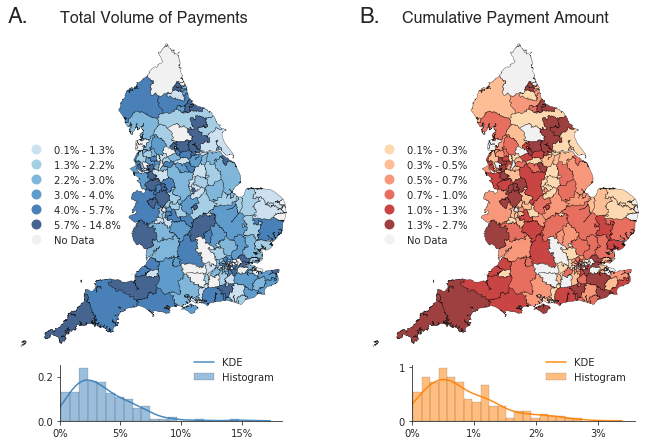

In [26]:
ccg_merged = make_ccg_to_gdf(pd.concat([ccg_pay_df,trust_pay_df]),
                             pay_df_cc_ccg, support_path)
gdf=make_gdf(ccg_merged, shape_path, support_path)
plot_choropleths_ccg(gdf, figure_path)
hide_toggle()

Trusts dont map exactly to boundaries, so we geocode their exact address and plot the same metrics:


The top 5 Trusts by %to VCS are: 

              dept  charity_amount  pc_amount
39   NHS_DHC_Trust      26356655.0  20.442575
10   NHS_BER_Trust       1174710.0   9.282505
85   NHS_LIP_Trust       6086158.0   8.686581
112  NHS_NOT_Trust      23935168.0   7.480028
28   NHS_CLC_Trust      11803069.0   7.252536


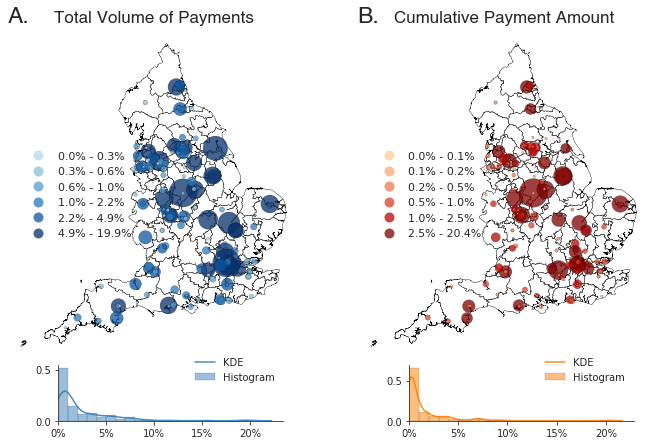

In [27]:
plot_choropleths_trusts(support_path, shape_path, figure_path,
                        trust_pay_df, pay_df_cc)
hide_toggle()

### 5.5 Charity Age Distribution

How do charities which recieve payments from the NHS differ in terms of their age in terms to those who don't?

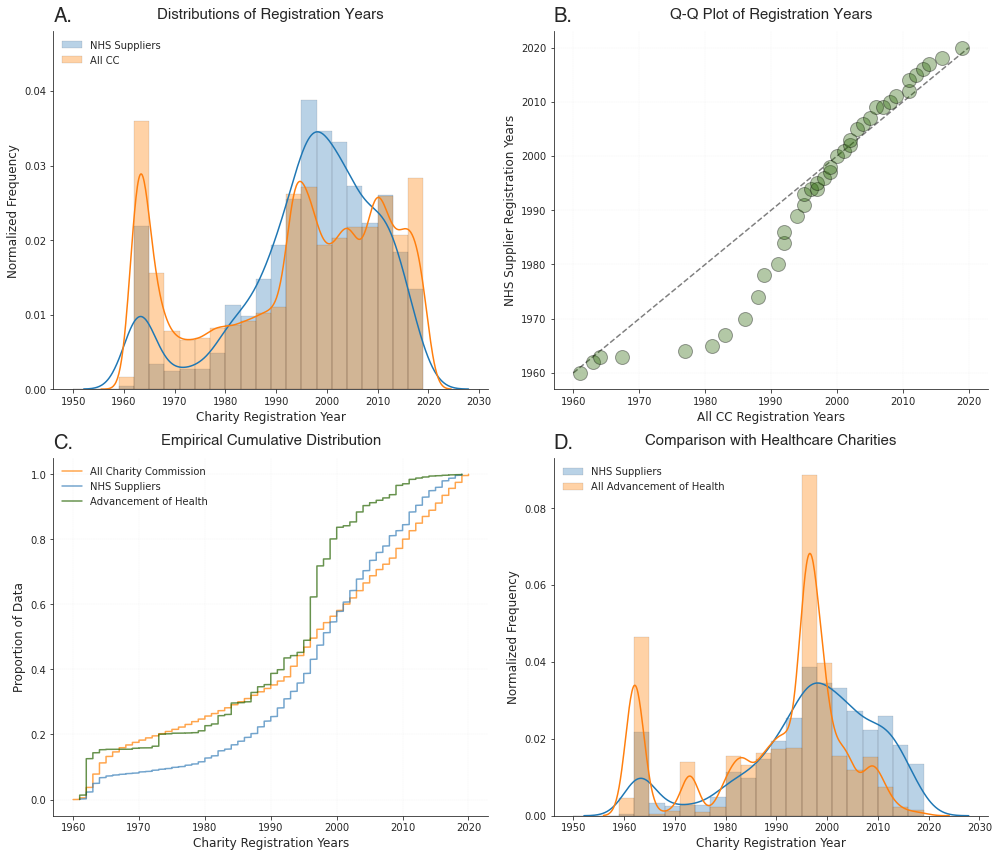

In [28]:
charity_age(pd.concat([trust_pay_df, ccg_pay_df], ignore_index=True),
            cc_sup, cc_name, cc_class, figure_path)

Do older, more established charities get _more_ income from NHS orgs?

In [29]:
more_or_less_by_age(cc_sup)

Full sample:

Correlation between age and amount:  0.14221231491261366
Correlation between age and count: 0.14641637283767156
Correlation between age and amount by rank:  0.21377807062981405
Correlation between age and count by rank: 0.1971996407294767
-------------------------------------------
Companies registered before 2012:

Correlation between age and amount:  0.13628024068047326
Correlation between age and count: 0.135769228878517
Correlation betwen age and amount, by rank:  0.19012274570118165
Correlation between age and count, by rank:  0.1697867215436507


### 5.6 Over TIme

How has this changed over time? First break it down by ICNPO, then aggregate up

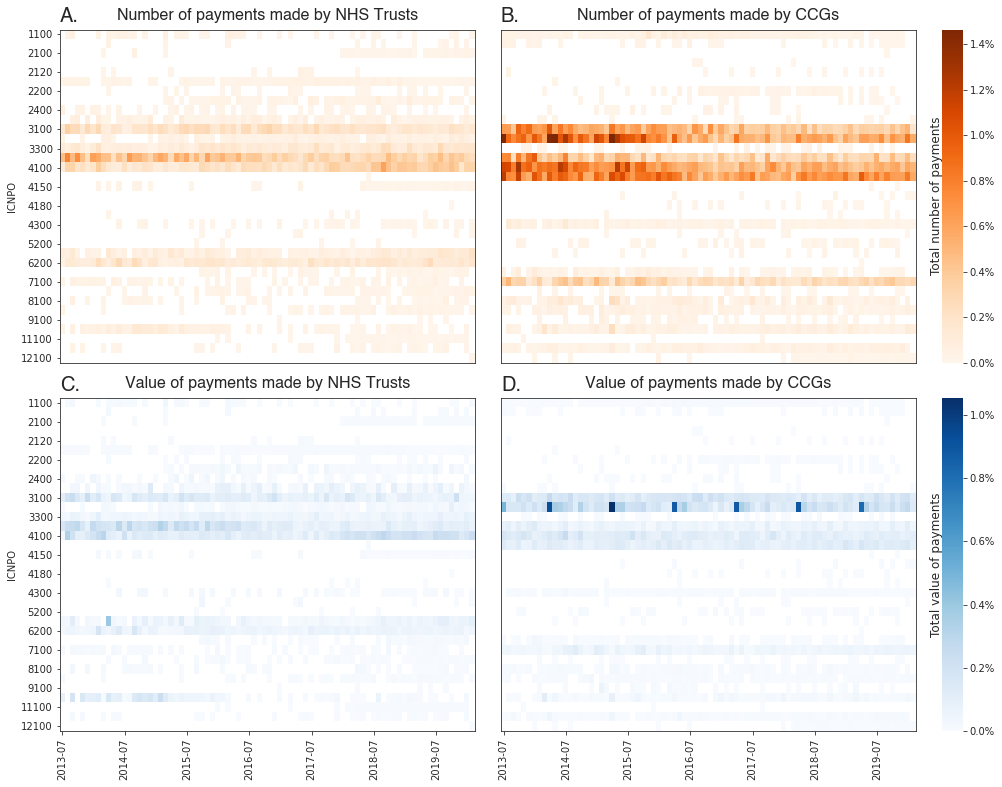

In [30]:
ts_trust_month, ts_icnpo_plot_trust = make_temporal_df(trust_pay_df, pay_df_cc_trust,
                                                      icnpo_df, cc_name)
ts_ccg_month, ts_icnpo_plot_ccg = make_temporal_df(ccg_pay_df, pay_df_cc_ccg,
                                                  icnpo_df, cc_name)
plot_heatmaps(ts_icnpo_plot_trust, ts_icnpo_plot_ccg, figure_path)

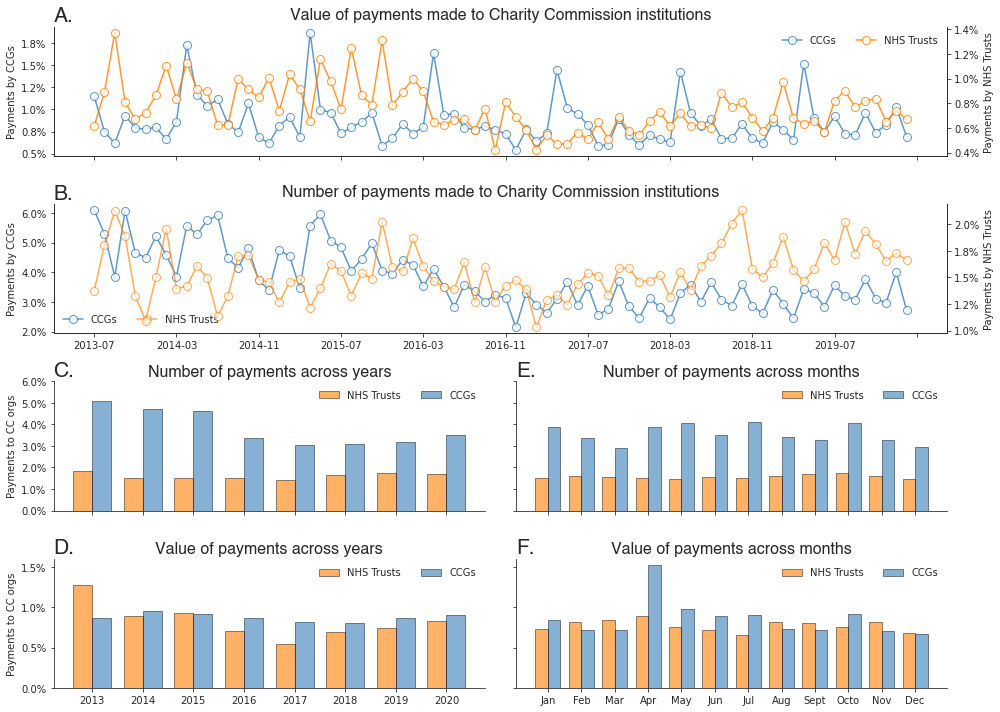

In [31]:
ts_ccg_annual = make_annual(ccg_pay_df, pay_df_cc_ccg, cc_name)
ts_trust_annual = make_annual(trust_pay_df, pay_df_cc_trust, cc_name)
ts_ccg_monthly = make_monthly(ccg_pay_df, pay_df_cc_ccg, cc_name)
ts_trust_monthly = make_monthly(trust_pay_df, pay_df_cc_trust, cc_name)
plot_temporal(ts_ccg_annual, ts_trust_annual, ts_ccg_monthly,
              ts_trust_monthly, ts_ccg_month, ts_trust_month, figure_path)